# Using actynf_jax & NumPyro to perform model inversion

This notebook uses the paradigms, model & parameters described [here](jax_Tmaze_comparison.ipynb).

Our goal here is to perform parameter estimation given a single measured training curve. To do this, 2 families of parameter estimation methods can be explored : 
- **Point estimates :** we return a single value for each parameter we're trying to infer. Two methods that give us a point estimate of model parameters are (see [this nice blog](https://agustinus.kristia.de/techblog/2017/01/01/mle-vs-map/) for a quick introduction):
    - Maximum Likelihood Estimation (MLE)
    - Maximum a Posteriori (MAP)

- **Distribution estimates :** we approximate the full posterior distribution for our parameter estimate. Here, we'll focus on Bayesian posteriors. Common bayesian solvers mostly use :
    - [MCMC (Markov Chain Monte-Carlo)](https://towardsdatascience.com/monte-carlo-markov-chain-mcmc-explained-94e3a6c8de11)
    - [Stochastic Variational Inference](https://andrewcharlesjones.github.io/journal/svi.html)

In this notebook, we'll be using [NumPyro](https://num.pyro.ai/en/latest/getting_started.html)'s probabilistic modeling capacities. 

**Note :** This notebook is heavily inspired by [this pymdp inversion pipeline](https://github.com/infer-actively/pymdp/blob/agent_jax/examples/model_inversion.ipynb) by Dimitrije Markovic & colleagues.


But first, let's generate some synthetic data that we will try to match !

In [18]:
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap,jit
from functools import partial


import actynf
print("Actynf version : " + str(actynf.__version__))

from actynf.demo_tools.tmaze.weights import get_T_maze_gen_process,get_T_maze_model,get_jax_T_maze_model
from actynf.jax_methods.layer_options import get_planning_options,get_action_selection_options,get_learning_options
from actynf.jax_methods.layer_training import synthetic_training
from actynf.jax_methods.jax_toolbox import convert_to_one_hot_list # This is a surprise tool that will help us later !

Actynf version : 0.1.36


In [2]:
T = 3
Th = 2

# _________________________________________ PROCESS ____________________________________________________________
# Those weights will remain the same for the whole notebook :
true_process_pHA = 1.0
true_process_pinit = 1.0
true_process_pwin = 0.98  # For a bit of noise !
true_A,true_B,true_D,U = get_T_maze_gen_process(true_process_pinit,true_process_pHA,true_process_pwin)

# _________________________________________ MODEL ______________________________________________________________
# We will try to infer some of those parameters based on training outcomes
true_model_pHA = 1.0
true_model_pwin = 0.98
true_model_context_belief = 0.5
true_model_hint_conf = 2.0
true_model_la = -4.0
true_model_rs = 2.0
true_alpha = 16.0
true_a,true_b,true_c,true_d,true_e,_ = get_T_maze_model(true_model_pHA,true_model_pwin,true_model_hint_conf,
                                        true_model_la,true_model_rs,true_model_context_belief)
# true_a,true_b,true_c,true_d,true_e,_ = get_jax_T_maze_model(true_model_pHA,true_model_pwin,true_model_hint_conf,true_model_la,true_model_rs,true_model_context_belief)

# Training options :
# 1. Planning the next action
true_Sh = 2                      # State horizon (or the number of inidividual states that will create their own branch)
true_remainder_state_bool = True # Do we create an additional branch with the remaining potential state density ?
true_Ph = 4                      # Policy horizon (or the number of individual actions that will be explored at each node)
true_option_a_nov = False
true_option_b_nov = False
true_additional_options_planning = False    
true_planning_options = get_planning_options(Th,"sophisticated",
                            true_Sh,true_Ph,true_additional_options_planning,
                            true_option_a_nov,true_option_b_nov,true_additional_options_planning)
# 2. Selecting the action from the planning posterior
true_alpha=4
true_as_options  =get_action_selection_options("stochastic",alpha=16)
# 3. Learning from past experiences
true_learn_options = get_learning_options(True,False,True,run_smoother=True)

training_parrallel_func = partial(synthetic_training,
    T=T,
    A=true_A,B=true_B,D=true_D,U=U,
    a0=true_a,b0=true_b,c=true_c,d0=true_d,e=true_e,
    planning_options=true_planning_options,
    action_selection_options = true_as_options,
    learning_options = true_learn_options)


# Let's run Ntrials trials for Nsubjects ! 
Ntrials = 10
Nsubj = 13
jitted_training_function = jit(vmap(lambda x : training_parrallel_func(x,Ntrials)))
rngkeys_all_subjs = jr.split(jr.PRNGKey(10),(Nsubj,))
[all_obs_arr,all_true_s_arr,all_u_arr,
    all_qs_arr,all_qs_post,all_qpi_arr,efes_arr,
    a_hist,b_hist,d_hist] = jitted_training_function(rngkeys_all_subjs)

# print("This is the data we'll be fitting ! ")
# print("Actions : ")
# print(all_u_arr)
# print("Observations : ")
# print(all_obs_arr)

# Observations should be in one_hot_vector form :
obs_vect_arr = convert_to_one_hot_list(all_obs_arr,[A_m.shape[0] for A_m in true_A])

fit_this_data = {
    "observations_vect":obs_vect_arr,
    "actions":all_u_arr
}
# print([o.shape for o in obs_vect_arr])
# print(all_u_arr.shape)

To fit this data, we're try to find the model parameters that best match the subject responses to the measured observations. 

We can look at this problem from two angles :
- For every value of initial parameter, we compute the full simulated training $\{ o_1,o_2,,...,o_{\tau},...,o_{Ntrials}\}$ and $\{ u_1,...,u_{\tau},...,u_{Ntrials}\}$ and compute a distance between the two trajectories. We pick the parameters with the smallest 'distance'. This method may be especially hard to fit due to the very high number of parameters that could produce similar trajectories, and the numerous local minima we may encounter.
- For each timestep, the agent uses the current timestep to make an inference and pick an action. Using the observed sequence of observations and agent actions, we can predict the evolution of the subject model across trials, and therefore predict the evolution of its decision making. To sum it up : 
    - We assume the agent observes the recorded value $o_{\tau,t}$
    - Based on the initial model parameter and previous observations, predict the infered hidden state $q(s_{\tau,t})$ and policy $q(\pi_{\tau,t})$ 
    - Compute the likelihood of observing $u_{\tau,t}$ given $q(\pi_{\tau,t})$ and the action selection method used
    - Proceed to the next timestep assuming that the action observed is in fact the **recorded** observation (instead of the one predicted by the current model).

In this notebook, we will focus on the second approach. This of course assumes that we're able to directly observe the outcomes of agent decision making. This is not always the case (e.g. BCIs), but we may be able to use some estimation methods to get around that...

For now, let's define the model we're going to invert ! 

In [3]:
# The numpyro primitives & methods we will need
import numpyro 
import numpyro.distributions as distr
from numpyro import plate,sample,deterministic
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.infer.util import log_density

# The actynf functions that return the likelihood given the empirical set of observations : 
from actynf.jax_methods.layer_training import empirical
from actynf.jax_methods.layer_pick_action import sample_action_pyro
# & the jaxified HMM parameters
from actynf.demo_tools.tmaze.weights import get_jax_T_maze_model

Np = U.shape[0]

##########################################" INVERSION "##########################################
# Define the model we're going to invert ! 

# # Fixed weight if we don't want to invert them : 
# fixed_model_a = jax.lax.stop_gradient(true_a)
# fixed_model_b = jax.lax.stop_gradient(true_b)
# fixed_model_c = jax.lax.stop_gradient(true_c)
# fixed_model_d = jax.lax.stop_gradient(true_d)
# fixed_model_e = jax.lax.stop_gradient(true_e)   # Static values for some parameters,


@vmap
def reparametrize(_Z):    
    # Every Active Inference model parameter depending on the value of the tensor Z
    _init_belief_pHA = jax.nn.sigmoid(_Z[0])
    _initial_hint_confidence = jnp.pow(jax.nn.softplus(_Z[1])+1.0,2) 
    _la = - jax.nn.softplus(_Z[2])
    _rs = jax.nn.softplus(_Z[3])
    _init_context_belief = jax.nn.sigmoid(_Z[4])
    _pwin = 0.98 # Fixed val
    return _init_belief_pHA,_initial_hint_confidence,_la,_rs,_init_context_belief,_pwin

def model(_data):        
    # Training options :
    # 1. Planning the next action
    model_Th = 2
    model_Sh = 2
    model_Ph = 4
    model_option_a_nov = False
    model_option_b_nov = False
    model_additional_options_planning = False    
    model_remainder_state_bool = True
    model_planning_options = get_planning_options(model_Th,"sophisticated",
                            model_Sh,model_Ph,model_remainder_state_bool,
                            model_option_a_nov,model_option_b_nov,model_additional_options_planning)
    # 2. Selecting the action from the planning posterior
    model_alpha = 4
    model_as_options  =get_action_selection_options("stochastic",alpha=model_alpha)
    # 3. Learning from past experiences
    model_learning_options = get_learning_options(True,False,True,run_smoother=True)

    model_action_likelihood = jit(vmap(partial(empirical,
                            planning_options = model_planning_options,
                            learning_options = model_learning_options))) # These will be the same across subjects !


    # The data we're going to fit : 
    _observations_vector = _data["observations_vect"] 
    _empirical_actions = _data["actions"]  # Numpyro sample seems to only support index vals ?
    _emp_actions_vect = jax.nn.one_hot(_empirical_actions,Np)

    _N_subj = _empirical_actions.shape[-3]
    with plate("subject",_N_subj):
        # Priors over the infered parameters, in parameter space : 
        _Z = sample("Theta",distr.Uniform(-5,5).expand([5]).to_event(1))
        _init_belief_pHA,_initial_hint_confidence,_la,_rs,_init_context_belief,_pwin = reparametrize(_Z)
        
        # Every Active Inference model parameter depending on the value of the tensor Z
        _init_belief_pHA = deterministic("clue_belief",_init_belief_pHA)
        _initial_hint_confidence = deterministic("clue_str",_initial_hint_confidence)
        _la = deterministic("loss_aversion",_la)
        _rs = deterministic("reward_seeking",_rs)
        _init_context_belief = deterministic("context_belief",_init_context_belief)
        _pwin = _pwin # Fixed (for now)
        
        # Convert to active inference parameter space
        _a,_b,_c,_d,_e,_u = vmap(get_jax_T_maze_model)(_init_belief_pHA,_pwin,_initial_hint_confidence,_la,_rs,_init_context_belief)
            
        # # Model posteriors prediction for these parameters
        [training_qs_arr,training_qs_post,training_qpi_arr,
            training_a_post,training_b_post,training_d_post] = model_action_likelihood(_observations_vector,_emp_actions_vect,
                                _a,_b,_c,_d,_e,_u)
        
        # # pyro sampling:
        sample_action_pyro(training_qpi_arr,model_as_options,observed_action=_empirical_actions)

with handlers.seed(rng_seed=123):
    model(fit_this_data)

# For the plotting ! 
coords = {
    'idx': jnp.arange(Nsubj),
    'vars': jnp.arange(5), 
}
dims = {'Theta': ["idx", "vars"], 'clue_belief': ["idx"], 'clue_str': ["idx"],
                    'loss_aversion': ["idx"],
                    'reward_seeking': ["idx"], 
                    'context_belief': ["idx"]}
data_kwargs = {
    "dims": dims,
    "coords": coords,
}

We can get a graph representation of the model we've built (but keep in mind that the trial and timesteps dimension are comprised in the "actions" box)

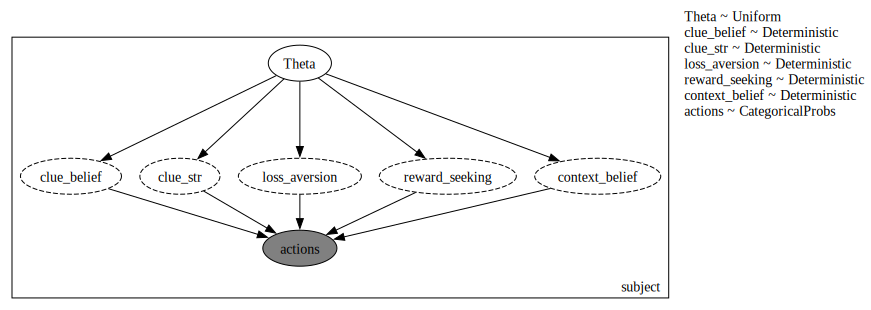

In [4]:
import sys,os
os.environ["PATH"] += os.pathsep + 'C:\\Users\\annic\\OneDrive\\Bureau\\MainPhD\\code\\venvs\\Graphviz\\bin'
graph = numpyro.render_model(model, model_args=(fit_this_data,), render_distributions=True,render_params=True) 
graph   

## MCMC estimation

First, let's try to infer the correct parameters by performing a MCMC estimation of the parameters : 


sample: 100%|██████████| 600/600 [3:00:53<00:00, 18.09s/it, 63 steps of size 5.58e-02. acc. prob=0.91]   


{'Theta': Array([[[ 4.295018  ,  3.7064056 ,  4.90508   ,  3.9134097 ,
         -0.80366075],
        [ 3.527944  , -3.4029903 ,  4.2076283 ,  4.03104   ,
         -0.45936346],
        [ 4.5681295 ,  1.3822275 ,  4.977787  ,  4.527862  ,
         -0.3240502 ],
        ...,
        [ 3.027742  ,  2.773081  ,  4.10461   ,  3.5539265 ,
         -0.5713579 ],
        [ 4.7260847 , -4.3506703 ,  4.9732094 ,  3.4863381 ,
         -0.07921368],
        [ 3.2691908 , -2.061883  ,  4.080041  ,  4.485304  ,
         -0.7002118 ]],

       [[ 3.0250306 , -0.23314357,  4.432337  ,  2.4346304 ,
         -0.6226224 ],
        [ 4.387602  ,  3.8443458 ,  3.4744132 ,  3.7422931 ,
         -0.65761447],
        [ 3.4546976 , -2.636329  ,  4.9790974 ,  4.5889006 ,
         -0.31129152],
        ...,
        [ 3.3842516 ,  0.5316371 ,  4.4329696 ,  4.5551353 ,
         -0.58442175],
        [ 3.9653432 ,  4.666501  ,  4.9711313 ,  3.988152  ,
         -0.48790216],
        [ 4.410167  ,  2.3003316 ,  4.

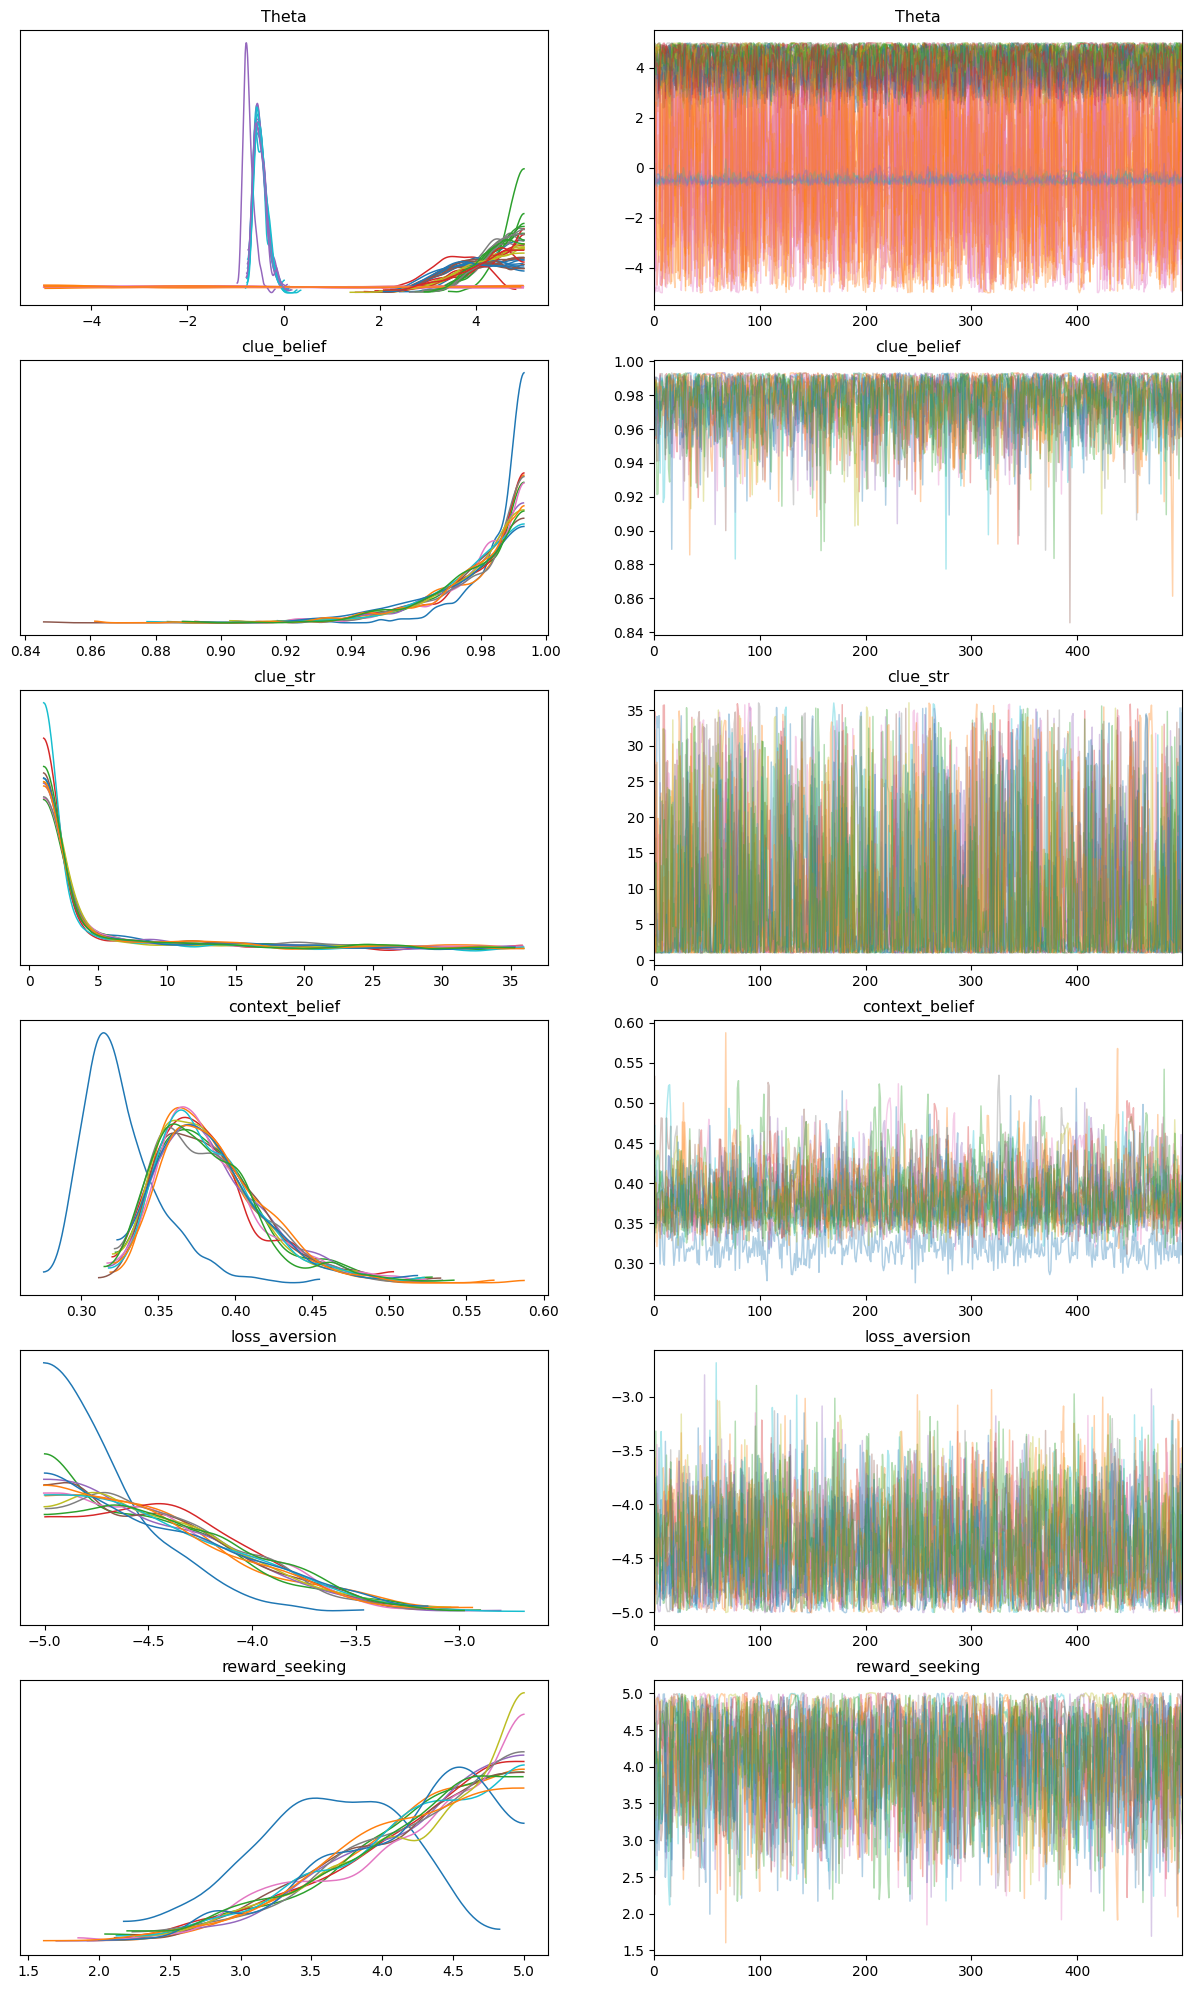

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Theta[0, 0]",4.300,0.512,3.386,4.997,0.028,0.021,264.0,259.0,NaN
"Theta[0, 1]",-0.045,2.966,-4.619,4.753,0.129,0.143,547.0,371.0,NaN
"Theta[0, 2]",4.672,0.275,4.164,4.999,0.015,0.011,332.0,220.0,NaN
"Theta[0, 3]",3.564,0.565,2.484,4.520,0.037,0.027,227.0,382.0,NaN
"Theta[0, 4]",-0.729,0.111,-0.915,-0.526,0.006,0.005,333.0,327.0,NaN
...,...,...,...,...,...,...,...,...,...
reward_seeking[8],4.220,0.633,3.038,5.006,0.054,0.040,99.0,86.0,NaN
reward_seeking[9],4.154,0.630,2.963,5.006,0.039,0.029,202.0,155.0,NaN
reward_seeking[10],4.131,0.606,2.929,5.005,0.025,0.018,496.0,348.0,NaN
reward_seeking[11],4.136,0.624,3.030,5.000,0.036,0.027,250.0,182.0,NaN


In [5]:
import matplotlib.pyplot as plt
import arviz as az
import corner  

# MODEL FITTING USING MCMC
num_warmup, num_samples = 100, 500
mcmc = MCMC(NUTS(model=model), num_warmup=num_warmup, num_samples=num_samples,num_chains=1)
mcmc.run(jr.PRNGKey(0), fit_this_data) 

posterior_samples = mcmc.get_samples()
print(posterior_samples)
mcmc.print_summary() 

data_mcmc = az.from_numpyro(posterior = mcmc, **data_kwargs)
az.plot_trace(data_mcmc, compact=True, figsize=(15, 25));
plt.show()

# Inference data :
inf_data = az.from_numpyro(mcmc)
az.summary(inf_data)

The posteriors may also be affected by some elements during the training (here, because the cheese was systematically on the right, it resulted in the agent picking right almost always after some point in the trial). For the inference, this led to a high posterior probability of the agent's initial belief being biaised towards this side, even if it wasn't the case. This is because we also assumed a uniform prior on the strength of this belief, adding to the estimation uncertainty.

In any case, while we achieved a successful paramater estimation method, it took quite a bit of time to run ! Let's try the same inference with stochastic variational inference (SVI).

In [6]:
# inferenace with SVI and autoguides
import optax
from numpyro.infer import SVI, Trace_ELBO, Predictive
from numpyro.infer.autoguide import AutoMultivariateNormal

rng_key = jr.PRNGKey(0)

num_iters = 1000
guide = AutoMultivariateNormal(model)
optimizer = numpyro.optim.optax_to_numpyro(optax.chain(optax.adabelief(1e-3)))
svi = SVI(model, guide, optimizer, Trace_ELBO(num_particles=10))
rng_key, _rng_key = jr.split(rng_key)
svi_res = svi.run(_rng_key, num_iters, fit_this_data)

100%|██████████| 1000/1000 [23:37<00:00,  1.42s/it, init loss: 8273.7549, avg. loss [951-1000]: 2405.6965]


Text(0.5, 0, 'iter step')

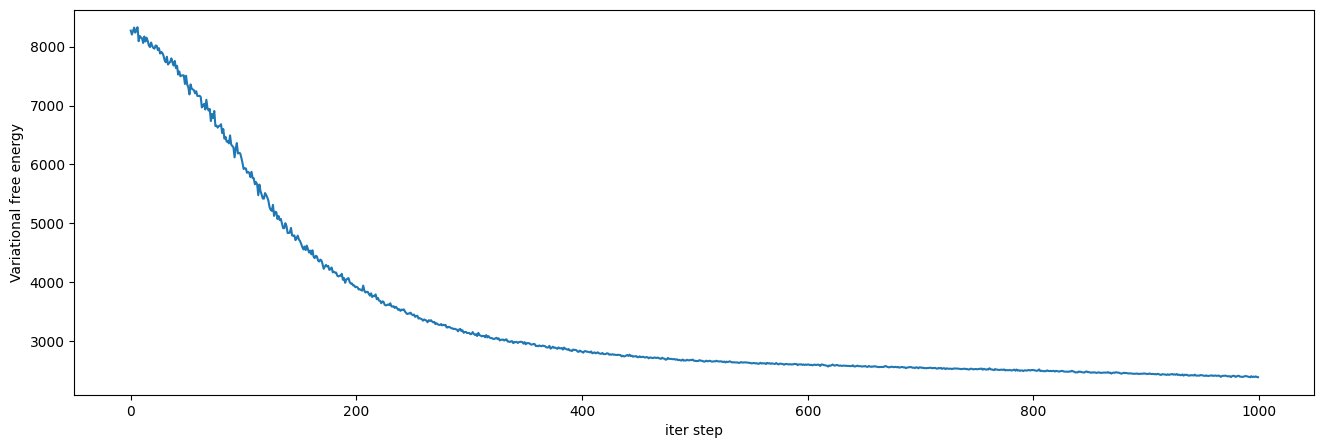

In [20]:
# Training curve : 
plt.figure(figsize=(16,5))
plt.plot(svi_res.losses)
plt.ylabel('Variational free energy')
plt.xlabel('iter step')


Nice ! And the processing time was much more reasonable, even on a single CPU !

In [7]:
rng_key, _rng_key = jr.split(rng_key)
pred = Predictive(
    model, 
    guide=guide, 
    params=svi_res.params, 
    num_samples=1000, 
    return_sites=["clue_belief", "clue_str", "loss_aversion","reward_seeking","context_belief"]
)
post_sample = pred(_rng_key, fit_this_data)

for key in post_sample:
    post_sample[key] = jnp.expand_dims(post_sample[key], 0)
    
data_svi = az.convert_to_inference_data(post_sample, group="posterior", **data_kwargs)

Let's now plot these results and see if they seem ok !

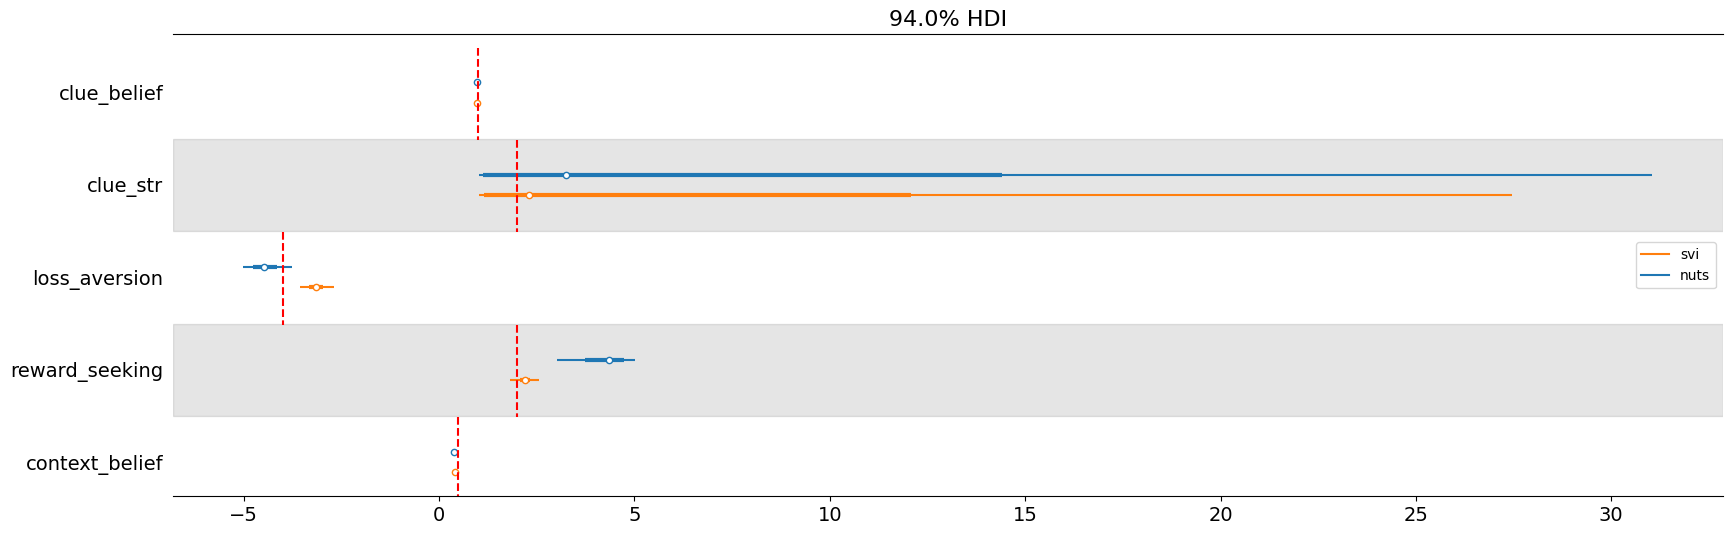

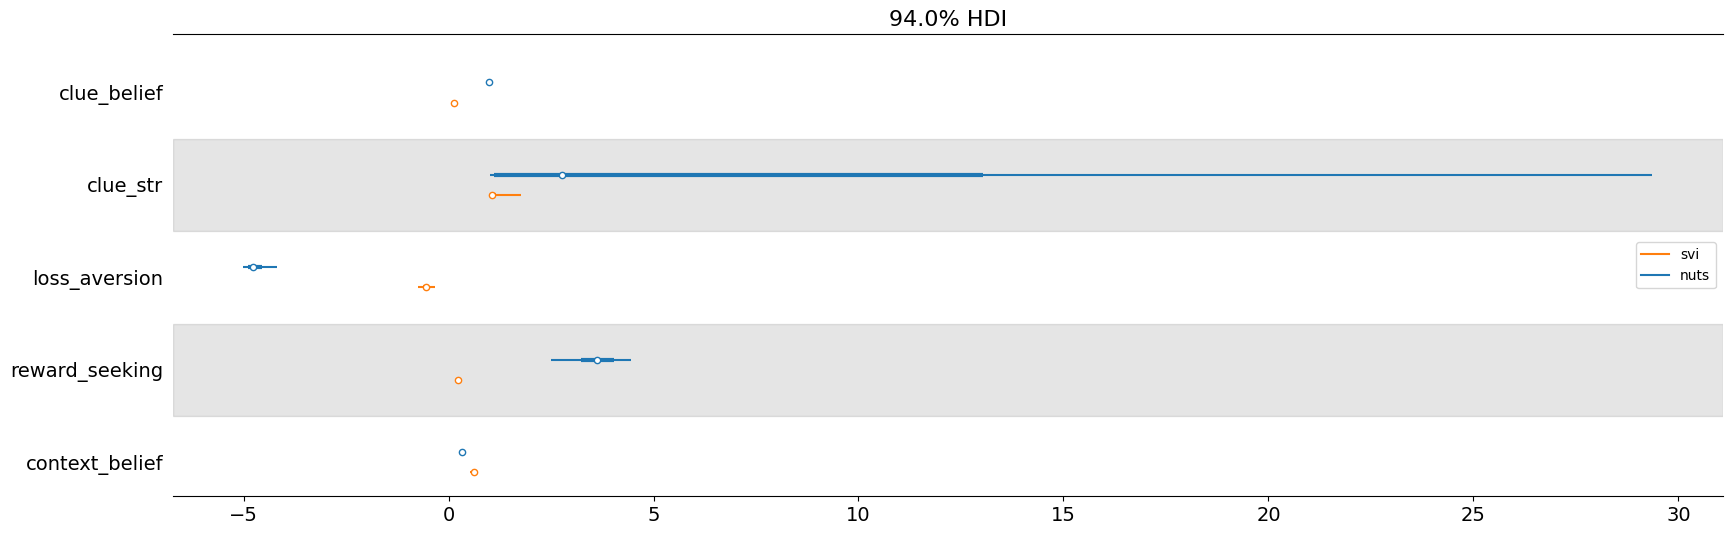

In [32]:
# A good inference with seemingly better results than NUTS (subject 6)
axes = az.plot_forest(
    [data_mcmc, data_svi],
    model_names = ["nuts", "svi"],
    kind='forestplot',
    var_names=["clue_belief", "clue_str", "loss_aversion","reward_seeking","context_belief"],
    coords={"idx": 6},
    combined=True,
    figsize=(20, 6)
)
# Show true values (this is very ugly :D)
true_vals = [true_model_pHA,true_model_hint_conf,true_model_la,true_model_rs,true_model_context_belief]
ymin, ymax = axes[0].get_ylim()
y0 = ymax-1.5
step_size = (ymax-ymin)/5.0
for val in true_vals:
    axes[0].vlines([val], y0, y0-step_size, ls='--',color='red')
    y0 = y0-step_size
plt.show()

# A bad inference that (probably) fell into a local minimum (subject 0)
axes = az.plot_forest(
    [data_mcmc, data_svi],
    model_names = ["nuts", "svi"],
    kind='forestplot',
    var_names=["clue_belief", "clue_str", "loss_aversion","reward_seeking","context_belief"],
    coords={"idx": 0},
    combined=True,
    figsize=(20, 6)
)
# Show true values (this is very ugly :D)
true_vals = [true_model_pHA,true_model_hint_conf,true_model_la,true_model_rs,true_model_context_belief]
ymin, ymax = axes[0].get_ylim()
y0 = ymax-1.5
step_size = (ymax-ymin)/5.0
for val in true_vals:
    axes[0].vlines([val], y0, y0-step_size, ls='--',color='red')
    y0 = y0-step_size
plt.show()